# Audio pattern recognition

In [1]:
import seaborn as sns

from src.utility import show_duration_distribution, plot_history
from src.data_processing import FeatureExtractor
from src.dataset import Dataset

sns.set_theme()
speech_path, song_path, save_path = "data/raw/speech", "data/raw/song", "data/processed"

## Audio duration analysis
Plot of the average speech and song duration. The feature extractor fixes the len to the max len. 

In [2]:
# MAX_LEN = show_duration_distribution(speech_path, song_path, limit_per_actor=3)
# print("Max len of data samples: ", MAX_LEN)

## Preprocessing and feature extraction

The first step of the methodology consists in extracting the first 13 mfcc from the speech and song files.

In [3]:
MAX_LEN = 140526
fe = FeatureExtractor(speech_path=speech_path, 
                      song_path=song_path,
                      save_path=save_path, 
                      verbose=True, 
                      file_per_actor_limit=-1, 
                      audio_fixed_size=MAX_LEN)

data = fe.get_training_data(overwrite=False)

Data found on disk


# SVM, K-NN and NN comparison

After extracting features, the first part of the project consists in comparing the performance of Neural Networks, SVM and K-NN. They are tested on the emotion label.

In [4]:
d = Dataset(data, augment=True)
X_train, X_val, X_test, y_train, y_val, y_test = d.get_training_data(data="merge", label="emotion", 
                                                                     train_perc=0.6, val_perc=0.2)
X_train.shape, X_val.shape, X_test.shape

((2885, 312), (963, 312), (481, 312))

### SVM training

In [5]:
from sklearn.svm import SVC

x, _ = y_train.shape
x2, _ = y_val.shape
reshaped_y_train = y_train.reshape(x)
reshaped_y_val = y_val.reshape(x2)

svm_model = SVC()
svm_model.fit(X_train, reshaped_y_train)
print(f"SVM Accuracy on train: {svm_model.score(X_train, reshaped_y_train)}")
print(f"SVM Accuracy on validation:  {svm_model.score(X_val, reshaped_y_val)}")

SVM Accuracy on train: 0.7195840554592721
SVM Accuracy on validation:  0.6272066458982347


### KNN training
Here K is set to be sqrt of the number of training samples.

In [6]:
from sklearn.neighbors import KNeighborsClassifier as KNN

k = int(len(y_train)**(1/2))
k += int((k%2)==0)

knn_model = KNN(k)
knn_model.fit(X_train, reshaped_y_train)    

print(f"{k}-NN Accuracy on validation: {knn_model.score(X_val, reshaped_y_val)}")

53-NN Accuracy on validation: 0.48078920041536866


### Neural network training
We now train a simple neural network on the data, evaluating the impact of using only audio, speech or both, each one with or without augmentation. 

Each test computes it's own class weights on the training data, the epochs are set to 300 and the model minimizing validation accuracy is selected. 

In [7]:
from prometheus_client import Counter
from sklearn.utils import compute_class_weight
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.regularizers import L1, L2, L1L2

from collections import Counter
import numpy as np

def class_weight(y):
    seq = y.copy().reshape(y.shape[0])
    t, L = len(np.unique(seq)), len(seq)
    return {k : L/(t*v) for k, v in Counter(seq).items()}

def build_nn():
    model = Sequential()
    model.add(Input(shape=X_train[0].shape))
    model.add(Dense(150, activation="relu", kernel_regularizer=L1L2(l1=1e-5, l2=1e-4), bias_regularizer=L2(1e-4), activity_regularizer=L2(1e-5)))
    model.add(Dropout(0.1))  # <-- and here
    model.add(Dense(75, activation="relu", kernel_regularizer=L1L2(l1=1e-5, l2=1e-4), bias_regularizer=L2(1e-4), activity_regularizer=L2(1e-5)))
    model.add(Dropout(0.1))  # <-- and here
    model.add(Dense(8, activation="softmax"))
    model.compile(optimizer='sgd', loss=SparseCategoricalCrossentropy(), metrics=["accuracy"])
    return model

def train_nn(train_data, val_data, test_data, build_fun, epochs, verbose):
    
    m = build_fun()
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath="data/models/nn.hdf5",
        save_weights_only=True,
        monitor='val_accuracy',
        mode='max',
        save_best_only=True)
    
    w = class_weight(train_data[1])
    history = m.fit(train_data[0], train_data[1], validation_data=val_data, 
                        epochs=epochs, verbose=verbose, callbacks=[model_checkpoint_callback], class_weight=w)
    plot_history(history)
    
    m.load_weights("data/models/nn.hdf5")
    l, a = m.evaluate(test_data[0], test_data[1], verbose=0)
    print(f"TEST: Loss: {l}, accuracy: {a}")
    return m, history


Audio files: song, augmentation: False


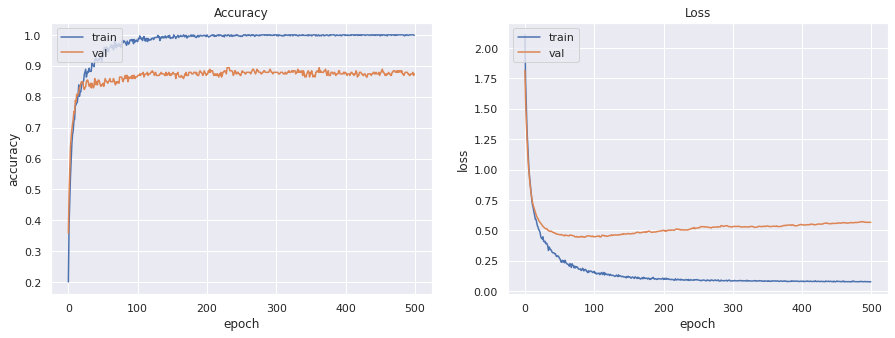

TEST: Loss: 0.3584236800670624, accuracy: 0.8939393758773804

Audio files: song, augmentation: True


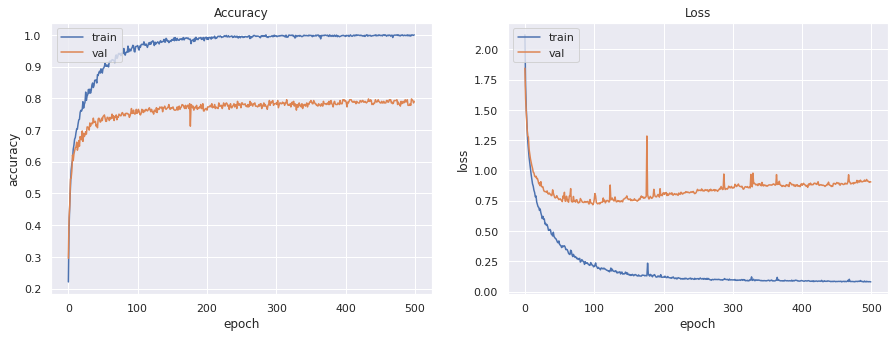

TEST: Loss: 0.454177588224411, accuracy: 0.8838383555412292

Audio files: speech, augmentation: False


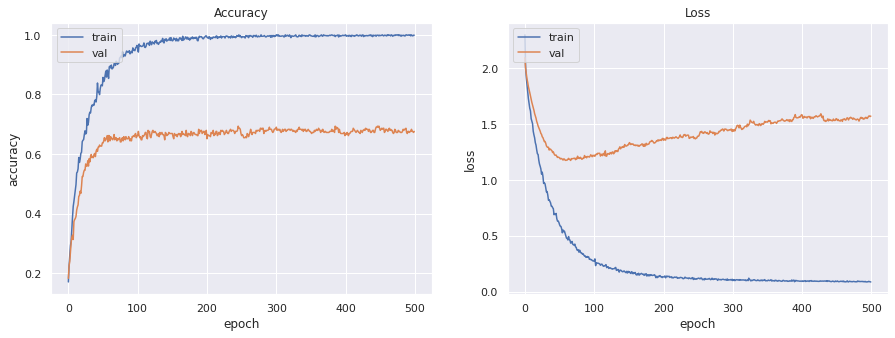

TEST: Loss: 1.5452929735183716, accuracy: 0.6302816867828369

Audio files: speech, augmentation: True


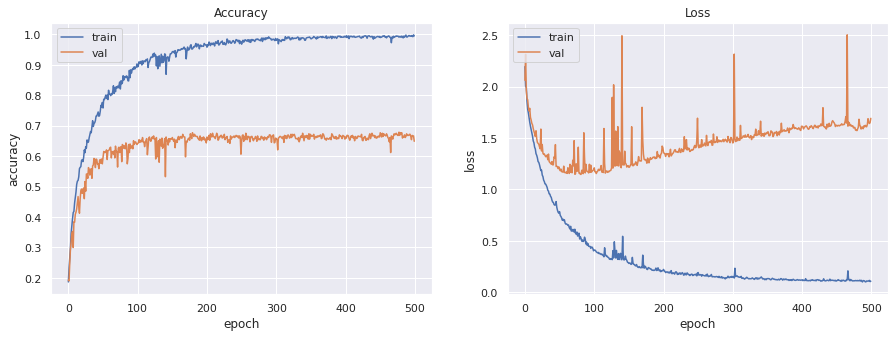

TEST: Loss: 1.833627462387085, accuracy: 0.6302816867828369

Audio files: merge, augmentation: False


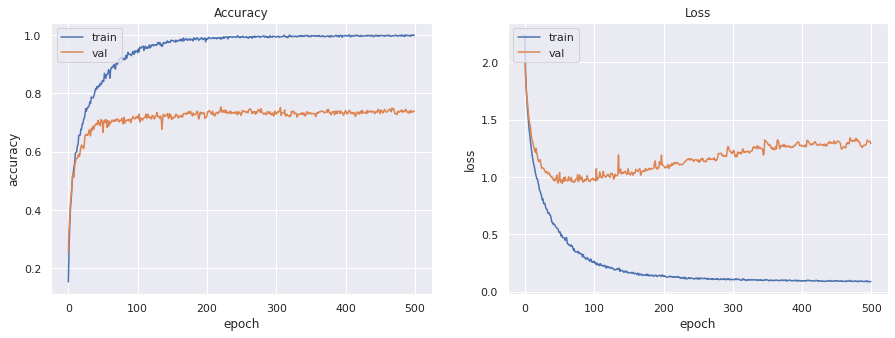

TEST: Loss: 0.9960722327232361, accuracy: 0.7401247620582581

Audio files: merge, augmentation: True


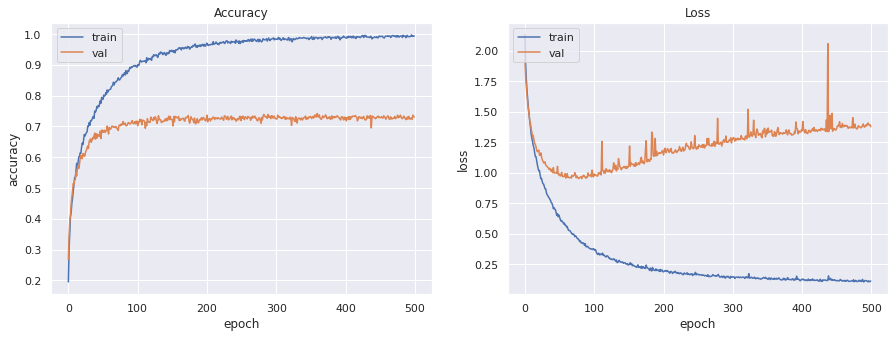

TEST: Loss: 1.3701192140579224, accuracy: 0.7463617324829102


In [8]:
setups = zip(["song", "song", "speech", "speech", "merge", "merge"], [False, True]*3)

for mode in setups:
    print(f"\nAudio files: {mode[0]}, augmentation: {mode[1]}")
    X_train, X_val, X_test, y_train, y_val, y_test = Dataset(data, augment=mode[1]).get_training_data(mode[0], "emotion", train_perc=0.6, val_perc=0.2)
    _, _ = train_nn((X_train, y_train), (X_val, y_val), (X_test, y_test), build_nn, epochs=500, verbose=0)

### Observations
Performance on speech is much worse than song, this could mean that the feature extraction needs to be tuned for the first case. 
Augmentation seems pointless for song or speech classification, but it gives a small improvement on the merge case.

# Splitting the classification task

The idea is now to split the classification task, by first finding the gender or the vocal channel, and then perform classification on the sub problem. This could improve classification as the final task is simpler.

In [9]:
X_train, X_val, X_test, y_train, y_val, y_test = d.get_training_data("merge", "gender", train_perc=0.6, val_perc=0.2)

### Gender model 
Training a network to find gender of actor. This is a much easier task than before.

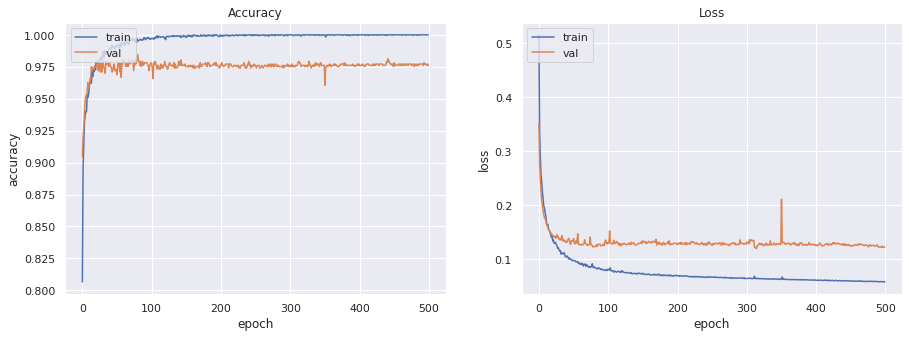

TEST: Loss: 0.11767513304948807, accuracy: 0.9896050095558167


In [10]:
def build_binary_nn():
    model = Sequential()
    model.add(Input(shape=X_train[0].shape))
    model.add(Dense(150, activation="relu", kernel_regularizer=L1L2(l1=1e-5, l2=1e-4), bias_regularizer=L2(1e-4), activity_regularizer=L2(1e-5)))
    model.add(Dropout(0.1))
    model.add(Dense(75, activation="relu", kernel_regularizer=L1L2(l1=1e-5, l2=1e-4), bias_regularizer=L2(1e-4), activity_regularizer=L2(1e-5)))
    model.add(Dropout(0.1))
    model.add(Dense(1, activation="sigmoid"))
    model.compile(optimizer='sgd', loss="binary_crossentropy", metrics=["accuracy"])
    return model

gender_network, _ = train_nn((X_train, y_train), (X_val, y_val), (X_test, y_test), build_binary_nn, epochs=500, verbose=0)

### Male model 
The first model recognizes emotions from male speech and songs.

In [11]:
X_train, X_val, X_test, y_train, y_val, y_test = d.get_training_data("merge", "all", train_perc=0.6, val_perc=0.2)

def extract_gender_data(X, y):
    l = [[], []]
    for i, e in enumerate(y):
        l[e[2]].append(i)
        
    return X[l[0]], X[l[1]], y[l[0]], y[l[1]]

X_train_m, X_train_f, y_train_m, y_train_f = extract_gender_data(X_train, y_train)
X_val_m, X_val_f, y_val_m, y_val_f = extract_gender_data(X_val, y_val)
X_test_m, X_test_f, y_test_m, y_test_f = extract_gender_data(X_test, y_test)

# slicing and reshaping for later training
y_train_m = y_train_m[:, 0].reshape(y_train_m.shape[0], 1)
y_train_f = y_train_f[:, 0].reshape(y_train_f.shape[0], 1)
y_val_m = y_val_m[:, 0].reshape(y_val_m.shape[0], 1)
y_val_f = y_val_f[:, 0].reshape(y_val_f.shape[0], 1)
y_test_m = y_test_m[:, 0].reshape(y_test_m.shape[0], 1)
y_test_f = y_test_f[:, 0].reshape(y_test_f.shape[0], 1)

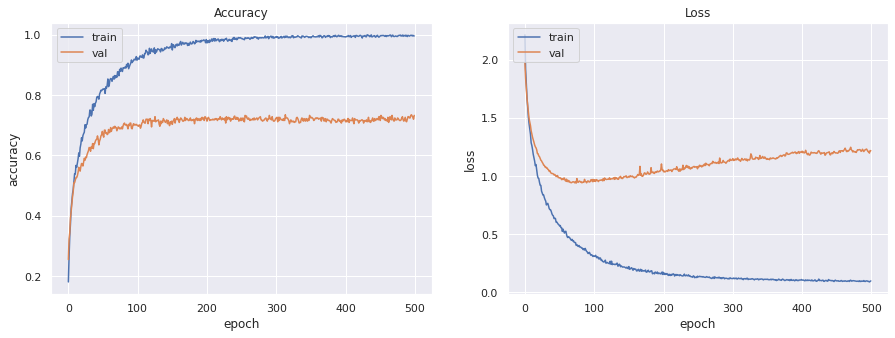

TEST: Loss: 1.1114503145217896, accuracy: 0.7637130618095398


In [12]:
male_model, _ = train_nn((X_train_m, y_train_m), (X_val_m, y_val_m), (X_test_m, y_test_m), build_nn, epochs=500, verbose=0)

### Female model 
The second model recognizes emotions from female speech and songs.

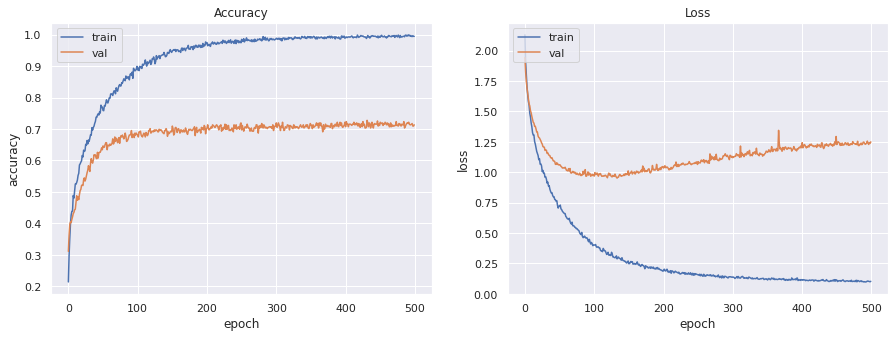

TEST: Loss: 1.148574948310852, accuracy: 0.7172130942344666


In [13]:
female_model, _ = train_nn((X_train_f, y_train_f), (X_val_f, y_val_f), (X_test_f, y_test_f), build_nn, epochs=500, verbose=0)

In [19]:
a = (0.7637130618095398 * len(y_test_m) + 0.7172130942344666 * len(y_test_f))/(len(y_test_m) + len(y_test_f))
print(f"Overall accuracy: {a}")

Overall accuracy: 0.7401247206695858
